---

## VALIDATION STRATEGY

- Now, that we have seen Tree based models were giving better results. So, we will use RandomForest Regressor Model in this notebook and we will define our validation strategy to make sure that the model we build is robust.

We need to find out what would be the 
- right number of validation sets such that we can get reliable estimates of RMSLE
- right size of the training data to get a robust model


---


In [1]:
# importing the required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

from datetime import timedelta

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the updated(preprocessed) train data
train_data = pd.read_csv('updated_dataset/updated_train_data.csv')

In [3]:
# top results of the data
train_data.head()

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS
0,14-Jan-09,367,1111009477,1.57,0,0,13
1,14-Jan-09,367,1111009497,1.39,0,0,20
2,14-Jan-09,367,1111085319,1.88,0,0,14
3,14-Jan-09,367,1111085345,1.88,0,0,29
4,14-Jan-09,367,1111085350,1.98,0,0,35


In [4]:
# convert the WEEK_END_DATE to datetime
train_data['WEEK_END_DATE'] = pd.to_datetime(train_data['WEEK_END_DATE'])

In [5]:
# first and last week in the dataset
train_data.WEEK_END_DATE.min() , train_data.WEEK_END_DATE.max()

(Timestamp('2009-01-14 00:00:00'), Timestamp('2011-09-28 00:00:00'))

In [6]:
# number of weeks in the dataset
train_data.WEEK_END_DATE.nunique()

142

In [7]:
# create an array of unique week dates
week = train_data.WEEK_END_DATE.unique()

In [8]:
# read the other datasets
product_data = pd.read_csv('updated_dataset/updated_product_data.csv')
store_data = pd.read_csv('updated_dataset/updated_store_data.csv')

In [9]:
merged_data = train_data.merge(product_data,how='left', on='UPC')
merged_data = merged_data.merge(store_data, how='left', left_on='STORE_NUM', right_on='STORE_ID')

In [10]:
merged_data = merged_data.drop(columns=['STORE_ID'])

In [11]:
# look at data in the first row 
merged_data.loc[0]

WEEK_END_DATE                2009-01-14 00:00:00
STORE_NUM                                    367
UPC                                   1111009477
BASE_PRICE                                  1.57
FEATURE                                        0
DISPLAY                                        0
UNITS                                         13
MANUFACTURER_1                                 1
MANUFACTURER_2                                 0
MANUFACTURER_3                                 0
MANUFACTURER_4                                 0
MANUFACTURER_5                                 0
MANUFACTURER_6                                 0
MANUFACTURER_7                                 0
MANUFACTURER_8                                 0
MANUFACTURER_9                                 0
CATEGORY_1                                     1
CATEGORY_2                                     0
CATEGORY_3                                     0
CATEGORY_4                                     0
SUB_CATEGORY_1      

---
#### `VALIDATION STRATEGY`

---

***For a single iteration, we define a training period on which we will train the model and then we will have `one week gap` and `validate` on the next week and again `one week gap` and `test` on the next week***

We discussed during data collection  that the suppliers need 1 week head start for supplying the requested goods to warehouses so we will predict not for the next week but next to the next week as that is the week for which our forecasts would be used in practical scenario.


![](images/cross_validation.png)

---

***Now, we need to find out what would be the optimal `number of validation sets` and optimal `number of months` on which we should validate the data.***

---



- Define a function `validation_df` that will take the parameters array of `week`, `no_of_months`, `no_of_validation` and returns a dataframe that contains the imformation like:

 * `week` unique week_end_dates array
 * `no_of_months` training data duration that needs to be considered
 * `no_of_validation` number of validation sets that needs to be created with training period as specified

---
---
 *  `train_start`  Data split train set start week
 *  `train_end`  Data split train set end week
 *  `no_days_train`  Number of days we have in the particular validation set
 *  `validation_week`  Data split validation week
 *  `test_week`  Data split test week
 *  `train_shape` Datapoints available in the train split 
 *  `validation_shape` Datapoints available in the validation week
 *  `test_shape` Datapoints available in the test week
---


---




In [12]:
# function to create validation data_frame
def validation_df(data, week, no_of_months, no_of_validation):
    
    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start'] = week[w-3-4*no_of_months]
        x_data['train_end'] = week[w-4]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train'] = x_data['train_end'] - x_data['train_start']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break
        
        
    datapoints = []

    for s in model_set :
        x = {}
        train_set = data[(data.WEEK_END_DATE >= s['train_start']) & (data.WEEK_END_DATE <= s['train_end'])]
        x['train_shape'] = train_set.shape[0]
        x['validation_shape']  = data[data.WEEK_END_DATE == s['validate_week']].shape[0]
        x['test_shape'] = data[data.WEEK_END_DATE == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)

    df = pd.DataFrame.from_dict(datapoints)
    df['no_days_train'] = df['no_days_train'] + timedelta(days=7)
    return df    

In [13]:
# validation sets for training size = 3 months and number of validation sets = 3
validation_df(merged_data, week, no_of_months= 3, no_of_validation= 3)

,train_shape,validation_shape,test_shape,train_start,train_end,validate_week,test_week,no_days_train,set_no
0,19647,1640,1642,2011-06-15,2011-08-31,2011-09-14,2011-09-28,84 days,set1
1,19657,1632,1638,2011-06-08,2011-08-24,2011-09-07,2011-09-21,84 days,set2
2,19654,1629,1640,2011-06-01,2011-08-17,2011-08-31,2011-09-14,84 days,set3


In [14]:
# validation sets for training size = 6 months and number of validation sets = 4
validation_df(merged_data, week, no_of_months= 6, no_of_validation= 4)

,train_shape,validation_shape,test_shape,train_start,train_end,validate_week,test_week,no_days_train,set_no
0,39294,1640,1642,2011-03-23,2011-08-31,2011-09-14,2011-09-28,168 days,set1
1,39308,1632,1638,2011-03-16,2011-08-24,2011-09-07,2011-09-21,168 days,set2
2,39308,1629,1640,2011-03-09,2011-08-17,2011-08-31,2011-09-14,168 days,set3
3,39308,1640,1632,2011-03-02,2011-08-10,2011-08-24,2011-09-07,168 days,set4


---

Now, we will calculate `EVALUATION METRIC - RMSLE` for each of the combination of traininig period size from 1 month to 12 months and number of validation sets from 1 to 5. We will use RandomForestRegressor Model 

---

In [15]:
# function to calculate the root mean squared log error
def get_msle(true, predicted) :
    return np.sqrt(msle( true, predicted))

# function to train the model 
# it will calculate and return the RMSLE on train and validation set
def my_model(train_d, validate_d):
    
    train_x = train_d.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    train_y = train_d['UNITS']
    
    valid_x = validate_d.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    valid_y = validate_d['UNITS']
    
    model_RFR = RandomForestRegressor(max_depth=20,random_state=0)
    model_RFR.fit(train_x, train_y)
            
    predict_validate = model_RFR.predict(valid_x)
    predict_validate = predict_validate.clip(min=0)
    
    return get_msle(valid_y, predict_validate)
    

# function will extract the train and validation set using validation dataframe
# The defined model will train on each of the set and the average RMSLE and standard deviation on validation 
    
def train_model(df,no_of_month):
    
    model_results = []
    for row in range(df.shape[0]):
        row = df.iloc[row]
        train_set = train_data[(train_data.WEEK_END_DATE >= row['train_start']) & (train_data.WEEK_END_DATE <= row['train_end'])]
        validate_set = train_data[train_data.WEEK_END_DATE == row['validate_week']]
        train_set['month'] = no_of_month
        validate_set['month'] = no_of_month
        model_results.append(my_model(train_set,validate_set))
        
    return np.mean(model_results), np.std(model_results)

---

Now, we define a function `get_matrix` that will take parameter `max_months` the number of months of training period and `max_cv` the number of validation sets.

It will return mean rmsle and standard deviation of the rmsle calculated over the different combinations of the months and validation sets.

---

In [16]:
# define get matrix
def get_matrix(max_months=1, max_cv=1):
    final_results_mean = []
    final_results_std = []
    
    for i in tqdm(range(1,max_months+1,1)):
        for j in range(1,max_cv+1,1):
            #print(i,j,'done')
            x = {}
            y = {}
            x['No_of_months'] = i
            x['validation_sets'] = j
            y['No_of_months'] = i
            y['validation_sets'] = j
            x['Results'] , y['Results'] = train_model(validation_df(merged_data, week, no_of_months=i, no_of_validation=j),i)
            final_results_mean.append(x)
            final_results_std.append(y)
            
            
    return pd.DataFrame.from_dict(final_results_mean).pivot_table(index= 'No_of_months', columns= 'validation_sets',fill_value=0) , pd.DataFrame.from_dict(final_results_std).pivot_table(index= 'No_of_months', columns= 'validation_sets',fill_value=0)

In [17]:
# let's first try with the months from range 1 to 12 and validation sets 1 to 5
final_mean, final_std = get_matrix(max_months=12,max_cv=5)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [04:07<00:00, 20.65s/it]


---

### Let's see how different combinations of training periods and validation sets give results.

---

In [18]:
# As the returned dataframe has multiindex columns, so drop one level
final_mean.columns = final_mean.columns.droplevel()

(12.5, -0.5)

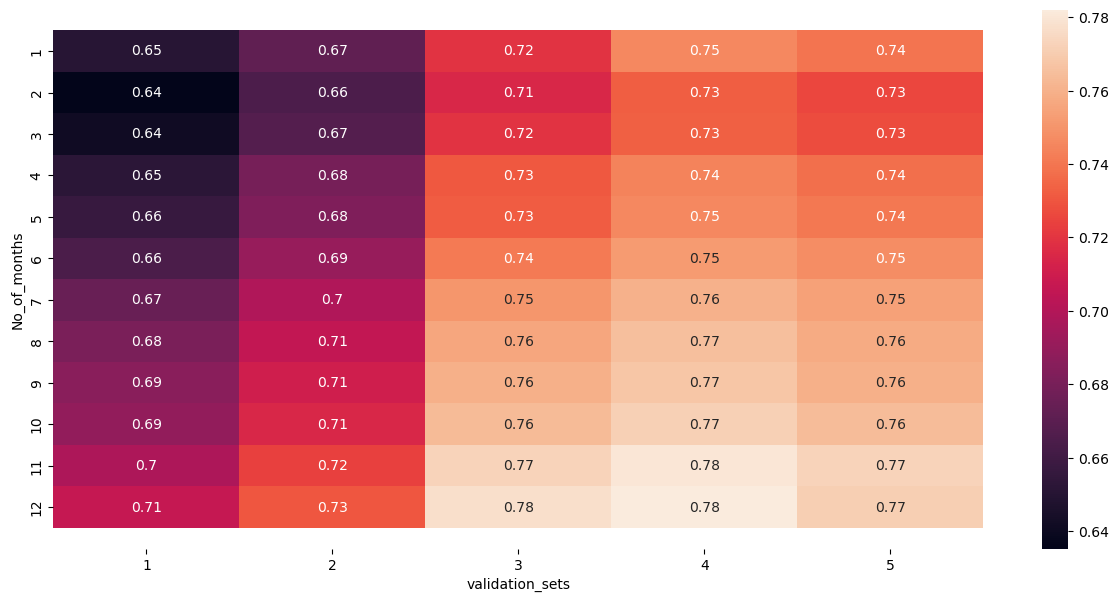

In [19]:
# correlation plot of the variables in the train data
plot = final_mean[final_mean.columns]
plt.figure(figsize=(15,7))
ax = sns.heatmap(plot,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

---


- We can see that, as we increase the size of the training period, the value of RMSLE increases. And for 2 months of train data we are getting the best score here and it keeps on increasing as we go further back. So, Let's calculate the results again by keeping the max training period to be 4 months and no of validation sets to be 15.


---

In [20]:
final_mean2, final_std2 = get_matrix(max_months=4,max_cv=15)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:03<00:00, 60.75s/it]


(4.5, -0.5)

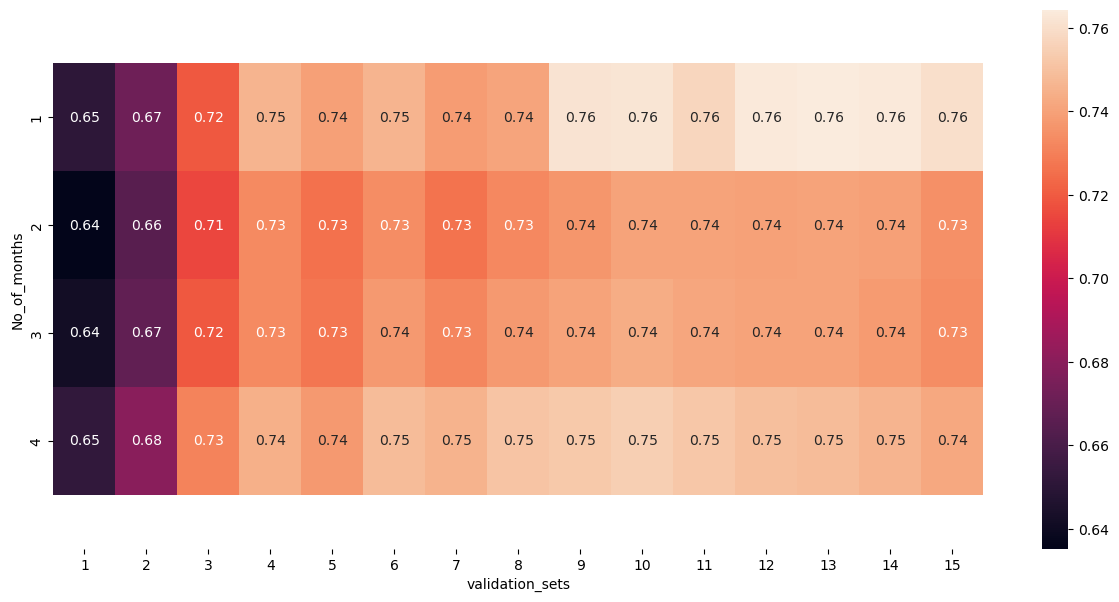

In [21]:
# correlation plot of the variables in the train data
final_mean2.columns = final_mean2.columns.droplevel()
plot = final_mean2[final_mean2.columns]
plt.figure(figsize=(15,7))
ax = sns.heatmap(plot,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

---

***Now, Using the training period of 2 months, the RMSLE value gets stable after the 9 validation sets to value 0.74.***

![](images/mean_prediction.png)

---



### Standard Deviation

Now, Let's see the standard deviation of the results over the validation sets.

(4.5, -0.5)

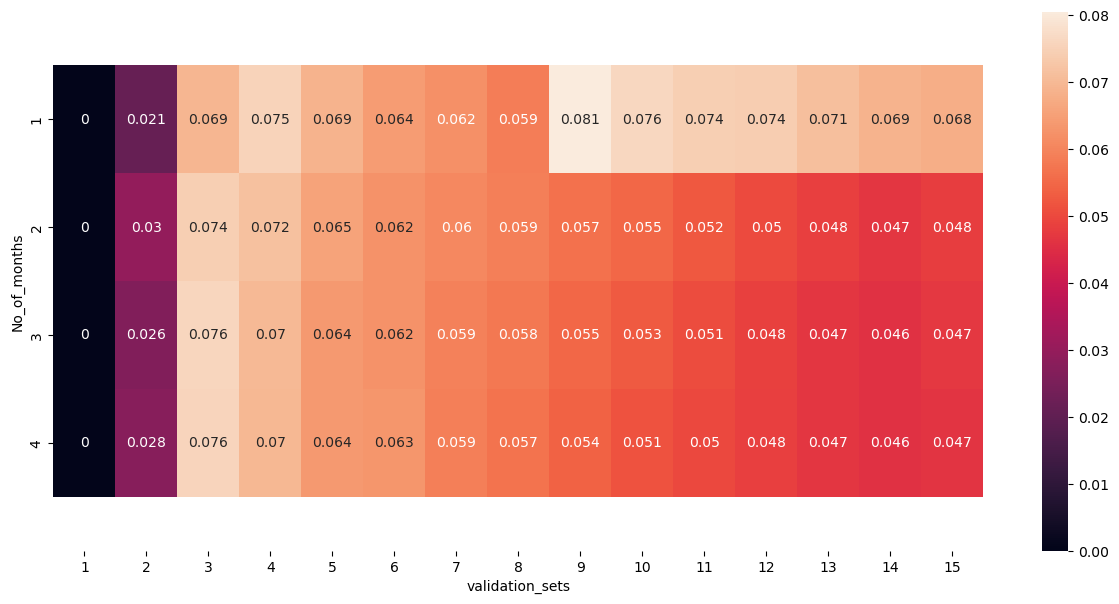

In [22]:
# correlation plot of the variables in the train data
final_std2.columns = final_std2.columns.droplevel()
plot = final_std2[final_std2.columns]
plt.figure(figsize=(15,7))
ax = sns.heatmap(plot,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

---
The lowest standard deviation is with 14 validation sets, and you can also see that the standard deviation increases with 15th validation set in both 2 and 3 months period results.

---

![](images/std_plot.png)


***So, we will validate our model with 2 months of training period and 14 validation sets.***

Now, that we have looked at the validation strategy, in the next module, using the same random forest model, we will try to generate new features to get even better scores.